In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd

import copy
from collections import namedtuple
import os
from dotenv import load_dotenv
import sys
import random
import shutil
import time

In [47]:
def create_qnn(output_dim):
    feature_map = ZZFeatureMap(output_dim)
    ansatz = RealAmplitudes(output_dim, reps=1)
    qc = QuantumCircuit(output_dim)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )

    return qnn

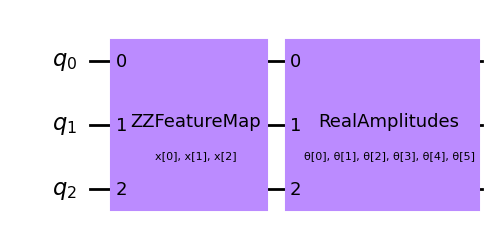

In [56]:
create_qnn(3).circuit.draw('mpl')

In [59]:
class AlexNetQNN(nn.Module):
    def __init__(self, output_dim, is_qnn=True):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 16 * 16, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

        self.is_qnn = is_qnn
        self.qantum_features = nn.Sequential(
            TorchConnector(create_qnn(output_dim)),
            # nn.Linear(4, output_dim),
            nn.Linear(1, 1),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        if self.is_qnn:
            x = self.qantum_features(x)
        return x, h

In [60]:
input_image = torch.rand(32, 3, 256, 256)
model = AlexNetQNN(output_dim=4, is_qnn=True)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
outputs, _ = model(input_image)
print(outputs.shape)


287,488,846 total parameters.
287,488,846 training parameters.
torch.Size([32, 1])
